[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/08-DWT/DWT_compression.ipynb)

# 2D-DWT image compression
Compressing color images with PNG and the YCoCg/2D-DWT. Remember to run [block_DCT_compression.ipynb](https://github.com/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/07-DCT/block__DCT_compression.ipynb) first. See also [DWT.ipynb](https://github.com/Sistemas-Multimedia/MRVC/blob/master/src/DWT.py).

## Parameters

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
import image_3 as image
import image_1 as component
import DWT
import pywt
!ln -sf ~/quantization/information.py .
!ln -sf ~/quantization/distortion.py .
import distortion
import YCoCg as YUV
!ln -sf ~/quantization/deadzone_quantizer.py .
import deadzone_quantizer as Q
import math
import information

In [2]:
wavelet = pywt.Wavelet("Haar")
#wavelet = pywt.Wavelet("db1")
wavelet = pywt.Wavelet("db5")
#wavelet = pywt.Wavelet("db15")
#wavelet = pywt.Wavelet("bior3.1")
#wavelet = pywt.Wavelet("bior3.3")
wavelet = pywt.Wavelet("bior5.5")
print(wavelet)

Wavelet bior5.5
  Family name:    Biorthogonal
  Short name:     bior
  Filters length: 12
  Orthogonal:     False
  Biorthogonal:   True
  Symmetry:       symmetric
  DWT:            True
  CWT:            False


In [3]:
HOME = os.environ["HOME"]
#test_image = "../sequences/stockholm/"
test_image = HOME + "/MRVC/sequences/lena_color/"
#test_image = "../sequences/lena_bw/"

In [4]:
N_levels = 5

In [5]:
N_components = 3

## First ... some handy routines

In [6]:
def __read_image(prefix):
    x = image.read(prefix, 0)
    if len(x.shape) == 2:
        extended_x = np.zeros(shape=(x.shape[0],  x.shape[1], 3), dtype=np.uint16) 
        extended_x[..., 0] = x
        return extended_x
    else:
        return x

def _write_compact_decomposition(decom, prefix, image_number):
    rows = decom[len(decom)-1][0].shape[0]*2
    cols = decom[len(decom)-1][0].shape[1]*2
    coms = decom[0].shape[2]
    image_shape = (rows, cols, coms)
    view = np.empty(image_shape, np.uint16)

    # LL subband
    view[0:decom[0].shape[0],
         0:decom[0].shape[1]] = (decom[0].astype(np.int32) + 32768).astype(np.uint16)

    for l in range(len(decom)-1):

        # LH
        view[0:decom[l+1][0].shape[0],
             decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] =\
                (decom[l+1][0].astype(np.int32) + 32768).astype(np.uint16)

        # HL
        view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
             0:decom[l+1][1].shape[1]] =\
                (decom[l+1][1].astype(np.int32) + 32768).astype(np.uint16)

        # HH
        view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
             decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] =\
                (decom[l+1][2].astype(np.int32) + 32768).astype(np.uint16)
            
    return image.write(view, prefix, image_number)
    
def write_compact_decomposition(decom, prefix, image_number):
    rows = decom[len(decom)-1][0].shape[0]*2
    cols = decom[len(decom)-1][0].shape[1]*2
    coms = decom[0].shape[2]
    image_shape = (rows, cols, coms)
    view = np.empty(image_shape, np.uint8)

    # LL subband
    view[0:decom[0].shape[0],
         0:decom[0].shape[1]] = (decom[0].astype(np.int16) + 128).astype(np.uint16)

    for l in range(len(decom)-1):

        # LH
        view[0:decom[l+1][0].shape[0],
             decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] =\
                (decom[l+1][0].astype(np.int16) + 128).astype(np.uint16)

        # HL
        view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
             0:decom[l+1][1].shape[1]] =\
                (decom[l+1][1].astype(np.int16) + 128).astype(np.uint16)

        # HH
        view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
             decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] =\
                (decom[l+1][2].astype(np.int16) + 128).astype(np.uint16)
            
    return image.write(view, prefix, image_number)

def read_compact_decomposition(prefix, image_number, N_levels):
    view = image.read(prefix, image_number)
    wavelet = pywt.Wavelet("Haar")
    decom = DWT.analyze(np.zeros_like(view), wavelet, N_levels)
    
    # LL subband
    decom[0][...] = view[0:decom[0].shape[0],
                         0:decom[0].shape[1]] - 32768
    
    for l in range(len(N_levels)):
        
        # LH
        decom[l+1][0] =\
            view[0:decom[l+1][0].shape[0],
                 decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] - 32668
            
        # HL
        decom[l+1][1] =\
            view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
                 0:decom[l+1][1].shape[1]] - 32768
            
        # HH
        decom[l+1][2] =\
            view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
                 decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] - 32768

    return decom

def entropy(decomposition):
    entro = information.entropy(decomposition[0].flatten().astype(np.int16))
    accumulated_entropy = entro * decomposition[0].size
    image_size = decomposition[0].size
    for sr in y[1:]:
        for sb in sr:
            entro = information.entropy(sb.flatten().astype(np.int16))
            accumulated_entropy += (entro * sb.size)
            image_size += sb.size
    avg_entropy = accumulated_entropy / image_size
    return avg_entropy

## Subband-components information

In [7]:
def info(sbc):
    max = sbc.max()
    min = sbc.min()
    max_min = max - min
    avg = np.average(sbc)
    dev = math.sqrt(np.var(sbc))
    entropy = information.entropy(sbc.flatten().astype(np.int16))
    energy = information.energy(sbc)
    avg_energy = information.energy(sbc)/sbc.size
    shape = sbc.shape
    return max, min, max_min, avg, dev, entropy, energy, avg_energy, shape

def subbands_info(decomp):
    print("sorting subband-components by entropy")
    print("sbc maximum mininum max-min average std-dev entropy        energy  avg-enegy shape")
    list_of_subbands_components = []
    sbc_index = 0
    accumulated_entropy = 0
    max_val = 0
    min_val = 10E10
    for c in range(N_components):
        sbc = decomp[0][..., c]
        infos = info(sbc)
        list_of_subbands_components.append((sbc_index, *infos))
        entropy = infos[5]
        accumulated_entropy += (entropy * sbc.size)
        if max_val < infos[0]:
            max_val = infos[0]
        if min_val > infos[1]:
            min_val = infos[1]
        sbc_index += 1
    for sr in decomp[1:]:
        for sb in sr:
            for c in range(N_components):
                sbc = sb[..., c]
                infos = info(sbc)
                list_of_subbands_components.append((sbc_index, *infos))
                entropy = infos[5]
                accumulated_entropy += (entropy * sbc.size)
                if max_val < infos[0]:
                    max_val = infos[0]
                if min_val > infos[1]:
                    min_val = infos[1]
                sbc_index += 1
    sorted_list_of_subbands_components = sorted(list_of_subbands_components, key=lambda x: x[6])[::-1]
    for _i in sorted_list_of_subbands_components:
        sbc_index, max, min, max_min, avg, dev, entropy, energy, avg_energy, shape = _i
        print(f"{sbc_index:3d} {max:7.1f} {min:7.1f} {max_min:7.1f} {avg:7.1f} {dev:7.1f} {entropy:7.1f} {energy:13.1f} {avg_energy:10.1f} {shape}")

    avg_entropy = accumulated_entropy / img.size
    print("Image path:", test_image)
    print("Wavelet name:", wavelet)
    print("Number of levels:", N_levels)
    print("Number of subbands:", (sbc_index+1)/3)
    print("Number of subband-components:", sbc_index+1)
    print("Average entropy in the wavelet domain:", avg_entropy)
    print("Entropy in the image domain:", information.entropy(img.flatten().astype(np.uint8)))
    print("Maximum coefficient value:", max_val)
    print("Minimum coefficient value:", min_val)
    print("Dynamic range in the transform domain:", max_val - min_val)
    print("Number of bits required for encoding the coefficients using integer numbers:", math.ceil(math.log(max_val - min_val)/math.log(2)))
    
img = image.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16) - 128) # -128 decreases maximum value of the DC coefficients
#YUV_img = YUV.from_RGB(img.astype(np.int16)) - 128# -128 decreases maximum value of the DC coefficients
decomp = DWT.analyze(YUV_img, wavelet, N_levels)
subbands_info(decomp)

image_3.read: /home/vruiz/MRVC/sequences/lena_color/000.png (512, 512, 3) uint8 512673 
sorting subband-components by entropy
sbc maximum mininum max-min average std-dev entropy        energy  avg-enegy shape
 15   535.8  -489.9  1025.7     0.8   114.2     8.1    13347429.7    13034.6 (32, 32)
  0  2092.7 -2106.9  4199.6  -225.2   896.1     7.9   218563321.8   853763.0 (16, 16)
  1  1880.4    54.7  1825.6  1189.3   423.4     7.8   407987142.6  1593699.8 (16, 16)
  6   977.9 -1095.9  2073.8    15.7   364.7     7.7    34105184.0   133223.4 (16, 16)
  2   -23.6  -951.6   928.0  -688.9   184.9     7.5   130253102.2   508801.2 (16, 16)
  3   553.8  -553.9  1107.7     0.8   127.1     7.3     4134982.3    16152.3 (16, 16)
  9   531.1  -463.0   994.1     6.9   136.9     7.2     4809691.6    18787.9 (16, 16)
  7   298.0  -288.5   586.5    -0.3    93.4     7.2     2233512.5     8724.7 (16, 16)
 12   290.6  -373.6   664.2    -0.7    54.3     7.0     3019159.9     2948.4 (32, 32)
  8   250.7  -202

Comments
1. Most of the energy (and entropy, i.e., information) is concentrated in the low-frequency subbands.
2. The wavelet domain is potentially more compressible than the image domain, because the entropy is smaller.
3. The number of bits required for representing the low-frequency subbands is significantly higher than the original 8-bits/component. This number depends on the wavelet filters, the number of levels of the transform, and the original image.

## Lossless compression

### Using the "glued" representation

image_3.read: /home/vruiz/MRVC/sequences/lena_color/000.png (512, 512, 3) uint8 512673 
image_3.write: /tmp/lossless000.png (512, 512, 3) uint16 713599 
output_length=713599
6
image_3.read: /tmp/lossless000.png (512, 512, 3) uint16 713599 
component=0 max=255 min=0 dtype=uint8
component=1 max=248 min=1 dtype=uint8
component=2 max=237 min=6 dtype=uint8


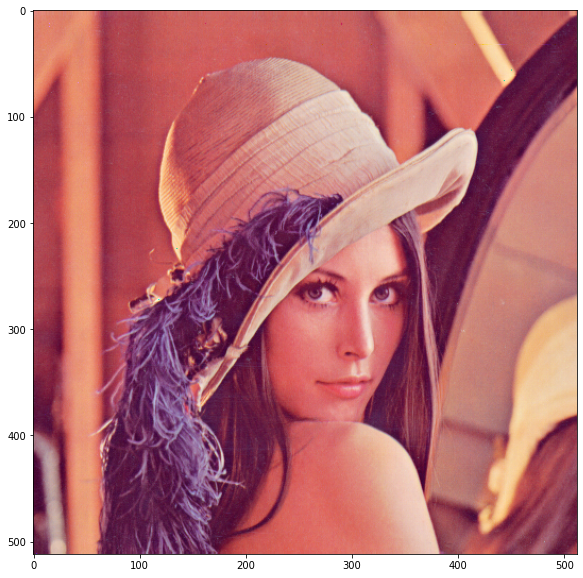

In [12]:
img = image.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16) - 128) # -128 decreases maximum value of the DC coefficients
decom = DWT.analyze(YUV_img, wavelet, N_levels)
decom_ = DWT.add(decom, 32768)
decom__ = DWT.set_type(decom_, np.uint16)
output_len, slices = DWT.write_glued(decom__, "/tmp/lossless", 0)
print(f"output_length={output_len}")
print(len(slices[0]))
_decom = DWT.read_glued(slices, "/tmp/lossless", 0)
_decom2 = DWT.add(_decom, -32768)
_YUV_img = DWT.synthesize(_decom2, wavelet, N_levels)
_img = (YUV.to_RGB(_YUV_img) + 128).astype(np.uint8)
image.show(_img)

### Using the "unglued" representation

In [9]:
def drange(x):
    return x.max() - x.min()

def add_offset(x):
    if drange(x) < 256:
        x = (x + 128).astype(np.uint8)
    else:
        x = (x + 32768).astype(np.uint16)
    return x

def sub_offset(x):
    if drange(x) < 256:
        x = (x - 128).astype(np.float64)
    else:
        x = (x - 32768).astype(np.float64)
    return x

In [11]:
img = image.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16) - 128) # -128 decreases maximum value of the DC coefficients
decom = DWT.analyze(YUV_img, wavelet, N_levels)
always_positive_decom = [add_offset(decom[0])] # always_positive_decom is PNG friendly
for sr in decom[1:]: # sr = spatial_resolution
    always_positive_sr = []
    for sb in sr: # sb = subband
        always_positive_sr.append(add_offset(sb))
    always_positive_decom.append(tuple(always_positive_sr))
#DWT.print_shapes(always_positive_decom)
output_len, slices = DWT.write_unglued(always_positive_decom, "/tmp/lossless", 0)
print(f"output_length={output_len}")
print(len(slices[0]))
always_positive_decom = DWT.read_unglued(slices, "/tmp/lossless", 0)
_decom = [sub_offset(always_positive_decom[0])]
for always_positive_sr in always_positive_decom[1:]:
    sr = []
    for always_positive_sb in always_positive_sr:
        sr.append(sub_offset(always_positive_sb))
    _decom.append(tuple(sr))
_YUV_img = DWT.synthesize(_decom, wavelet, N_levels)
_img = (YUV.to_RGB(_YUV_img) + 128).astype(np.uint8)
image.show(_img)

image_3.read: /home/vruiz/MRVC/sequences/lena_color/000.png (512, 512, 3) uint8 512673 
image_3.write: /tmp/losslessLL5000.png (16, 16, 3) uint16 1373 
image_3.write: /tmp/losslessLH5000.png (16, 16, 3) uint16 1208 
image_3.write: /tmp/losslessHL5000.png (16, 16, 3) uint16 1317 
image_3.write: /tmp/losslessHH5000.png (16, 16, 3) uint16 1227 
image_3.write: /tmp/losslessLH4000.png (32, 32, 3) uint16 3835 
image_3.write: /tmp/losslessHL4000.png (32, 32, 3) uint16 4483 
image_3.write: /tmp/losslessHH4000.png (32, 32, 3) uint16 3930 
image_3.write: /tmp/losslessLH3000.png (64, 64, 3) uint16 12466 
image_3.write: /tmp/losslessHL3000.png (64, 64, 3) uint16 15193 
image_3.write: /tmp/losslessHH3000.png (64, 64, 3) uint16 12924 
image_3.write: /tmp/losslessLH2000.png (128, 128, 3) uint16 42739 
image_3.write: /tmp/losslessHL2000.png (128, 128, 3) uint16 49913 
image_3.write: /tmp/losslessHH2000.png (128, 128, 3) uint8 29222 
image_3.write: /tmp/losslessLH1000.png (256, 256, 3) uint8 100334 
im

error: OpenCV(4.5.2) /tmp/pip-req-build-dccdjyga/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Lossy compression

In [ ]:
def _8bits_me(decomposition):
    '''Remove the least significant bit-planes of the <decomposition> until to represent each coefficient
    with 8 bits.
    '''
    N_levels = len(decomposition) - 1
    new_decomp = [decomposition[0].astype(np.int16) >> N_levels]
    levels_counter = N_levels - 1
    for resolution in decomposition[1:]:
        new_resol = []
        for subband in resolution:
            new_resol.append(subband.astype(np.int16) >> levels_counter)
        new_decomp.append(tuple(new_resol))
        levels_counter -= 1
    return new_decomp

def inverse_8bits_me(decomposition):
    N_levels = len(decomposition) - 1
    new_decomp = [decomposition[0].astype(np.int16) << N_levels]
    levels_counter = N_levels - 1
    for resolution in decomposition[1:]:
        new_resol = []
        for subband in resolution:
            new_resol.append(subband.astype(np.int16) << levels_counter)
        new_decomp.append(tuple(new_resol))
        levels_counter -= 1
    return new_decomp

In [ ]:
img = image.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16) - 128) # -128 decreases maximum value of the DC coefficients
decom = DWT.analyze(YUV_img, wavelet, N_levels)


decom8 = _8bits_me(decom)
decom8_ = DWT.add(decom8, 128)
decom8__ = DWT.set_type(decom8_, np.uint8)
output_len, slices = DWT.write_glued(decom8__, "/tmp/lossless", 0)
_decom8 = DWT.read_glued(slices, "/tmp/lossless", 0)
_decom8 = inverse_8bits_me(_decom8)
_decom8 = DWT.add(_decom8, -128)
_YUV_img8 = DWT.synthesize(_decom8, wavelet, N_levels)
_img = (YUV.to_RGB(_YUV_img8) + 128).astype(np.uint8)
image.show(_img)

In [ ]:
image.show(img - _img + 128)

In [ ]:
image.show(image.normalize(img - _img + 128))

In [ ]:
subbands_info(decom8)

### Quantization steps

The high dynamic range of the wavelet coefficients dificults the use 8-bit RGB PNG encoding, which is more compact that the 16-bit version. At this point, we have basically two alternatives:
1. Use a set of high enough quantization steps to keep the quantization indexes into 8 bits. However, notice that this probably is going to ignore most of the information of the high-frequency subbands because the amplitude of their coefficients are smaller than the smaller quantization step.
2. If the quality provided by the smaller quantization step is not enough, the unencoded (least significant) bit-planes of the coefficients can be compressed in a second 8-bit PNG image. TO-DO.
3. Check the dynamic range of the quantization idexes and if is larger than [-128, 127] use 16 bpps.

Notice that the smaller quantization step dependens on several factors:
1. The wavelet.
2. The number of levels.
3. The image content.

In [ ]:
#Q_steps = [4096, 2048, 1024, 512, 256, 128]
#Q_steps = [256, 128, 64, 32, 16]
#Q_steps = [64, 32, 16]
Q_steps = [32, 16, 8, 4, 2, 1, 0.5]
#Q_steps = [2]

## RD performance using uniform quantization among subbands

### Measuring the distortion in the transform domain

Compute the RD cuve of using uniform quantization in the YCoCg/wavelet domain. To estimate the distortion in the transform domain, we will suppose that the DWT is orthogonal and therefore, the distortion among subbands is uncorrelated, i.e., we can measure the quantization error in the wavelet domain, inside of the quantized subband-component.

In [ ]:
def drange(x):
    return x.max() - x.min()

def compute_Q_step(Q_step, level):
    step = int(math.ceil(Q_step * math.pow(2, N_levels)))
    print("Quantization step =", step)
    return step

img = image.read(test_image)
YUV_img = YUV.from_RGB(img.astype(np.int16) - 128)
#YUV_img = YUV.from_RGB(x.astype(np.int16))

DWT_RD_points = []
for Q_step in Q_steps:
    decom = DWT.analyze(YUV_img, wavelet, N_levels)
    LL = decom[0]
    _Q_step = compute_Q_step(Q_step, N_levels)
    #LL_k = Q.quantize(LL, Q_step << N_levels) # Baybe bettter Q.get_indexes()
    LL_k = Q.quantize(LL, _Q_step) # Baybe bettter Q.get_indexes()
    #assert (-128 <= LL_k).all() and (LL_k <= 127).all(), print("LL", Q_step, np.unique(LL_k))
    #LL_dQ = Q.dequantize(LL_k, Q_step << N_levels) # Q.get_signal()
    LL_dQ = Q.dequantize(LL_k, _Q_step) # Q.get_signal()
    if drange(LL_k) < 256:
        decom_k = [(LL_k + 128).astype(np.uint8)]
    else:
        decom_k = [(LL_k + 32768).astype(np.uint16)]
    decom_dQ = [LL_dQ]
    #dist = distortion.RMSE(LL, LL_dQ)
    #RMSE = (dist * LL.size)/x.size
    #print(gains[0], dist, gains[0] * dist, RMSE)
    #for i in range(4):
    #    for j in range(4):
    #        print(LL[i, j], LL_dQ[i, j])
    sbc_counter = 0
    levels_counter = N_levels - 1
    for sr in decom[1:]: # sr = spatial_resolution
        sr_k = []
        sr_dQ = []
        for sb in sr: # sb = subband
            #print(RMSE)
            #sb_k = Q.quantize(sb, Q_step << levels_counter)
            _Q_step = compute_Q_step(Q_step, levels_counter)
            sb_k = Q.quantize(sb, _Q_step)
            #assert (-128 <= sb_k).all() and (sb_k <= 127).all(), print(sbc_counter, np.unique(sb_k))
            #sb_dQ = Q.dequantize(sb_k, Q_step << levels_counter)
            sb_dQ = Q.dequantize(sb_k, _Q_step)
            if drange(sb_k) < 256:
                sr_k.append((sb_k + 128).astype(np.uint8))
            else:
                sr_k.append((sb_k + 32768).astype(np.uint16))
            sr_dQ.append(sb_dQ)
            #dist = distortion.RMSE(sb, sb_dQ)
            #print(gains[counter], dist, gains[counter] * dist, RMSE)
            #MSE += (dist * sb.size)/x.size
            sbc_counter += 1
        decom_k.append(tuple(sr_k))
        decom_dQ.append(tuple(sr_dQ))
        levels_counter += 1
    #subbands_info(decom_dQ)
    #BPP = (write_compact_decomposition(decom_k, f"/tmp/constant_{Q_step}_", 0)*8)/YUV_img.size
    #shifted_decom_k = DWT.add(decom_k, 128)
    #shifted_decom_k = DWT.set_type(decom_k, np.uint8)
    #BPP = (DWT.write(decom_k, f"/tmp/constant_{Q_step}_", 0)[0]*8)/YUV_img.size
    BPP = (DWT.write_unglued(decom_k, f"/tmp/constant_{Q_step}_", 0)[0]*8)/YUV_img.size
    YUV_img_dQ = DWT.synthesize(decom_dQ, wavelet, N_levels)
    img_dQ = np.clip(YUV.to_RGB(YUV_img_dQ), a_min=-128, a_max=127) + 128
    #img_dQ = YUV.to_RGB(YUV_img_dQ) + 128
    clipped_img_dQ = np.clip(img_dQ, a_min=0, a_max=255)
    RMSE = distortion.RMSE(img, clipped_img_dQ)
    print(f"{Q_step} {BPP} {RMSE}")
    DWT_RD_points.append((BPP, RMSE))
    image.show(img_dQ.astype(np.uint8), f"Reconstructed image (Q_step={Q_step})")

### Measuring the distortion in the image domain
This is the only choice for non-orthogonal transforms. We compute the inverse transform for each quantization step of each subband-component, and measure the distortion in the image domain.

### Compare both measurements (also with the DCT)

In [ ]:
DCT_RD_points = []
with open(HOME + "/Sistemas-Multimedia.github.io/milestones/07-DCT/DCT_uniform.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        DCT_RD_points.append((float(rate), float(_distortion)))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DCT_RD_points), label=f"DCT uniform Q")
pylab.plot(*zip(*DWT_RD_points), label=f"DWT uniform Q")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

## Again ... can we increase the RD performance using RDO?

Let's do that, for a given quantization step, the subband-components contribute approximately the same to que quality of the reconstruction.

Algorithm:
1. Read the image.
2. Transform to the YCoCg domain.
3. Transform each component to the DWT domain.
4. Find the RD curve for each subband-component.
5. Compute the slope of each step of each curve and put all the slopes in the same list.
6. Sort the previous list by the slope field.
7. Find the RD curve that progressively uses decending slopes.

### Read the image and move it to the YCoCg domain.

In [ ]:
img = image.read(test_image).astype(np.int16)
#YUV_img = YUV.from_RGB(img.astype(np.int16) - 128)
#YUV_img = YUV.from_RGB(img - 128)
#print((img-128).dtype)
#img_128 = img - 128
#img -= 128
#assert (img == img_128).all()
#print(img_128.dtype)
avgs = [np.average(img[...,c]) for c in range(3)]
#avgs = [128, 128 , 128]
print(f"avgs={avgs}")
for c in range(3):
    img[..., c] -= int(avgs[c])
YUV_img = YUV.from_RGB(img)

### Compute the DWT

In [ ]:
decom = DWT.analyze(YUV_img, wavelet, N_levels)

### Create a list of RD points for each RD curve (subband-component) and the corresponding lists of RD slopes between these points
The first coordinate of each point is the rate and the second coordinate is the corresponding distortion.
For rate=0, the RMSE is the energy of the subband-component.
Notice that no slope can be computed for the first point.

In [ ]:
RD_points = []
RD_slopes = []
for _c in range(N_components):
    sbc = decom[0][..., _c]
    RD_points.append([(0, information.average_energy(sbc))]) # Work with RMSE's that are average distortions
    RD_slopes.append([])
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            sbc = sb[..., _c]
            sbc_avg_energy = information.average_energy(sbc)
            # The first point of each RD curve has a maximum distortion equal
            # to the energy of the subband and a rate = 0
            RD_points.append([(0, sbc_avg_energy)])
            RD_slopes.append([])

### Show current points and slopes

In [ ]:
for _i,_j in enumerate(RD_points):
    print(_i,_j)
    if not ((_i+1) % 3):
        print('')

In [ ]:
def estimate_codestream_len(x, prefix):
    empty_x = np.zeros_like(x)
    real_BPP = component.write(x.astype(np.uint8), prefix)
    empty_BPP = component.write(empty_x.astype(np.uint8), prefix)
    return real_BPP - empty_BPP
    #return information.entropy(x.astype(np.int16).flatten())*x.size

### Populate the rest of points of each curve
There is a curve per subband-component. Distortion is measured in the transform domain. We use 16 bpp PNG files.

In [ ]:
# Subband LL
sbc_number = 0
for _c in range(N_components):
    sbc = decom[0][..., _c]
    Q_step_number = 0
    for Q_step in Q_steps:
        _Q_step = math.ceil(Q_step * math.pow(2, N_levels))
        #sbc_k = Q.quantize(sbc, Q_step)
        sbc_k = Q.quantize(sbc, _Q_step)
        #sbc_dQ = Q.dequantize(sbc_k, Q_step)
        sbc_dQ = Q.dequantize(sbc_k, _Q_step)
        RMSE = distortion.RMSE(sbc, sbc_dQ)
        #print(np.unique(sbc_k))
        #BPP = estimate_codestream_len((sbc_k + 128), f"/tmp/{_c}_{Q_step}_")*8/sbc.size
        #assert ((sbc_k + 128) >= 0).all()
        #BPP = component.write((sbc_k + 128).astype(np.uint8), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
        BPP = component.write((sbc_k + 32768).astype(np.uint16), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
        #BPP = information.PNG_BPP((sbc_k.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
        #sbc_BPP = information.entropy(sbc_k.astype(np.int16).flatten())
        point = (BPP, RMSE)
        RD_points[_c].append(point)
        delta_BPP = BPP - RD_points[_c][Q_step_number][0]
        delta_RMSE = RD_points[_c][Q_step_number][1] - RMSE
        if delta_BPP > 0:
            slope = delta_RMSE/delta_BPP
        else:
            slope = 0#100**10
        print("Q_step =", _Q_step, "BPP =", point[0], "RMSE =", point[1], "slope =", slope)
        #RD_slopes[_c].append((Q_step, slope, _c))
        RD_slopes[_c].append((_Q_step, slope, _c))
        Q_step_number += 1
    sbc_number += 1

# Rest of subbands
levels_counter = N_levels - 1
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            sbc = sb[..., _c]
            Q_step_number = 0
            for Q_step in Q_steps:
                _Q_step = math.ceil(Q_step * math.pow(2, levels_counter))
                #sbc_k = Q.quantize(sbc, Q_step)
                sbc_k = Q.quantize(sbc, _Q_step)
                #sbc_dQ = Q.dequantize(sbc_k, Q_step)
                sbc_dQ = Q.dequantize(sbc_k, _Q_step)
                RMSE = distortion.RMSE(sbc, sbc_dQ)
                BPP = component.write((sbc_k + 32768).astype(np.uint16), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
                #BPP = estimate_codestream_len(sbc_k, f"/tmp/{sbc_number}_{Q_step}_")*8/sbc.size
                #BPP = component.write(sbc_k.astype(np.uint8), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
                #BPP = information.PNG_BPP((sbc_k.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
                #sbc_BPP = information.entropy(sbc_k.astype(np.int16).flatten())
                point = (BPP, RMSE)
                RD_points[sbc_number].append(point)
                delta_BPP = BPP - RD_points[sbc_number][Q_step_number][0]
                delta_RMSE = RD_points[sbc_number][Q_step_number][1] - RMSE
                if delta_BPP > 0:
                    slope = delta_RMSE/delta_BPP
                else:
                    slope = 0#100**10
                print("Q_step =", _Q_step, "BPP =", point[0], "RMSE =", point[1], "slope =", slope)
                RD_slopes[sbc_number].append((_Q_step, slope, sbc_number))
                Q_step_number += 1
            sbc_number += 1

In [ ]:
for _i, _j in enumerate(RD_points):
    print(_i, _j)

In [ ]:
for _i, _j in enumerate(RD_slopes):
    print(_i, "---", _j)

## Remove points that do not belong to the convex-hull

In [ ]:
def filter_slopes(slopes):
    filtered_slopes = []
    slopes_iterator = iter(slopes)
    prev = next(slopes_iterator)
    for curr in slopes_iterator:
        if prev[0] < curr[0]:
            print(f"deleted {prev}")
        else:
            filtered_slopes.append(prev)
        prev = curr
    filtered_slopes.append(prev)
    return filtered_slopes

filtered_slopes = []
for i in RD_slopes:
    filtered_slopes.append(filter_slopes(i))

In [ ]:
# Show the slopes
RD_slopes_without_sbc_index = []
#RD_slopes_without_sbc_index.append([])
for _c in range(N_components):
    RD_slopes_without_sbc_index.append([])
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            RD_slopes_without_sbc_index.append([])
for Q_step in range(len(Q_steps)):
    RD_slopes_without_sbc_index[0].append(RD_slopes[0][Q_step][0:2])
sbc_number = 3
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            for Q_step in range(len(Q_steps)):
                RD_slopes_without_sbc_index[sbc_number].append(RD_slopes[sbc_number][Q_step][0:2])
            sbc_number += 1
print(RD_slopes_without_sbc_index[0])
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_slopes_without_sbc_index[0]), label="0", marker=0)
for sbc_number in range(10):
    pylab.plot(*zip(*RD_slopes_without_sbc_index[sbc_number]), label=f"{sbc_number}", marker=sbc_number)
pylab.title("Slopes of the RD curves of the subbands")
pylab.xlabel("Q_step")
pylab.ylabel("Slope")
plt.legend(loc="best")
pylab.show()

### Sort the slopes

In [ ]:
single_list = []
for Q_step in range(len(Q_steps)):
    single_list.append(tuple(RD_slopes[0][Q_step]))
sbc_number = 1
for sr in decom[1:]:
    for sb in sr:
        for _c in range(N_components):
            for Q_step in range(len(Q_steps)):
                single_list.append(tuple(RD_slopes[sbc_number][Q_step]))
            sbc_number += 1
sorted_slopes = sorted(single_list, key=lambda _x: _x[1])[::-1]

In [ ]:
sorted_slopes

In [ ]:
def show(d, s):
    c = 0
    for i in d[0]:
        print(s, i, end=' ')
        c += 1
        if c > 3:
            break
    for sr in d[1:]:
        for sb in sr:
            c = 0
            for i in sb:
                print(s, i, end=' ')
                c += 1
                if c > 3:
                    break
    print()

def _quantize(decom, Q_steps):
    decom_k = []
    decom_k.append(Q.quantize_components(decom[0], Q_steps[0:3]))
    for sr in decom[1:]:
        decom_k.append(Q.sr)
    print()
    return decom_k

def _dequantize(decom_k, Q_steps):
    decom_dQ = []
    decom_dQ.append(decom_k[0])
    for sr_k in decom_k[1:]:
        decom_dQ.append(sr_k)
    print()
    return decom_dQ
    
def quantize_components(x, Q_steps):
    '''Quantize each component of <x> using an independent quantization step.'''
    x_k = np.empty_like(x, dtype=np.int16)
    for c in range(x.shape[2]):
        x_k[..., c] = Q.quantize(x[..., c], Q_steps[c])
    return x_k

def quantize(decom, Q_steps):
    decom_k = []
    #decom_k.append(decom[0])
    decom_k.append(quantize_components(decom[0], Q_steps[0:3]))
    sbc_number = 3
    for sr in decom[1:]:
        sr_k = []
        for sb in sr:
            sb_k = quantize_components(sb, Q_steps[sbc_number:sbc_number + 3])
            sr_k.append(sb_k)
            sbc_number += 3
        #decom_k.append(sr)
        decom_k.append(tuple(sr_k))
    return decom_k

def dequantize_components(x_k, Q_steps):
    '''Dequantize each component of <x_k> using an independent quantization step.'''
    x_dQ = np.empty_like(x_k, dtype=np.int32)
    for c in range(x_k.shape[2]):
        x_dQ[..., c] = Q.dequantize(x_k[..., c], Q_steps[c])
    return x_dQ

def dequantize(decom_k, Q_steps):
    decom_dQ = []
    #decom_dQ.append(decom_k[0])
    decom_dQ.append(dequantize_components(decom_k[0], Q_steps[0:3]))
    sbc_number = 3
    for sr_k in decom_k[1:]:
        sr_dQ = []
        for sb_k in sr_k:
            sb_dQ = dequantize_components(sb_k, Q_steps[sbc_number:sbc_number + 3])
            sr_dQ.append(sb_dQ)
            sbc_number += 3
        #decom_dQ.append(sr_k)
        decom_dQ.append(tuple(sr_dQ))
    return decom_dQ
    
def quantize_sr(sr, Q_step):
    '''Quantize a spatial resolution of the DWT (3 multicomponent subbands) using
    3*N_components independent quantization steps'''
    return tuple([Q.quantize(i, Q_step) for i in sr])

def _quantize(decomposition, Q_steps):
    LL = decomposition[0]
    LL_k = np.empty_like(LL, dtype=np.int16)
    for _c in range(N_components):
        LLc = LL[..., _c]
        LL_k[..., _c] = LLc # Q.quantize(LLc, Q_steps[_c])
    decomposition_k = [LL_k]
    sbc_number = 3
    for sr in decomposition[1:]:
        #print("sr", len(sr))
        sr_k = []
        for sb in sr:
            sbc_k = np.empty_like(sb)
            for _c in range(N_components):
                sbc = sb[..., _c]
                #print(len(Q_steps), sbc_number)
                sbc_k[..., _c] = sbc # Q.quantize(sbc, Q_steps[sbc_number])
                #sbc_k = Q.quantize(sbc, Q_steps[sbc_number])
                sbc_number += 1
            sr_k.append(sbc_k)
        decomposition_k.append(tuple(sr_k))
    return decomposition
    #return decomposition_k

def _dequantize(decomposition_k, Q_steps):
    LL_k = decomposition_k[0]
    LL_dQ = np.empty_like(LL_k).astype(np.float64)
    for _c in range(N_components):
        LLc_k = LL_k[..., _c]
        LL_dQ[..., _c] = LLc_k# Q.dequantize(LLc_k, Q_steps[_c])
    decomposition_dQ = [LL_dQ]
    sbc_number = 3
    for sr_k in decomposition_k[1:]:
        sr_dQ = []
        #print("sr_k", len(sr_k))
        for sb_k in sr_k:
            sbc_dQ = np.empty_like(sb_k).astype(np.float64)
            for _c in range(N_components):
                sbc_k = sb_k[..., _c]
                #print(len(Q_steps), sbc_number)
                sbc_dQ[..., _c] = sbc_k #Q.dequantize(sbc_k, Q_steps[sbc_number])
                sr_dQ.append(sbc_dQ)
                sbc_number += 1
        decomposition_dQ.append(tuple(sr_dQ))
    return decomposition_k
    #return decomposition_dQ

def resolution_level(sb_number):
    '''Resolution level in decomposition.'''
    if sb_number > 0:
        return ((sb_number - 1) // 3) + 1
    else:
        return 0
    
def subband_index(sb_number):
    '''Subband index in resolution level.'''
    if sb_number > 0:
        return (sb_number % 3) - 1
    else:
        return 0

### Find the optimal RD curve

In [ ]:
optimal_DWT_RD_points = []
#y_prog = DWT.analyze(np.zeros_like(x), wavelet, N_levels)
#print(len(y_prog))
Q_steps_of_decomposition = 3*[10**6]
#Q_steps_of_decomposition = 3*[1]
#for sr in y_prog[1:]:
for sr in decom[1:]:
    #print(len(sr))
    for sb in sr:
        for _c in range(N_components):
            Q_steps_of_decomposition.append(10**6)
            #Q_steps_of_decomposition.append(1)
#print(Q_steps_by_subband)
slope_index = 0
for s in sorted_slopes:
    sbc_number = s[2]
    #print("sb_number", sb_number)
    Q_steps_of_decomposition[sbc_number] = s[0]
    #print(sb_number, Q_steps_by_subband[sb_number])
    #y_prog[resolution_level(sb_number)][subband_index(sb_number)] = y[resolution_level(sb_number)][subband_index(sb_number)]
    #y_k = quantize(y_prog, Q_steps_by_subband)
    decom_k = quantize(decom, Q_steps_of_decomposition)
    BPP = (write_compact_decomposition(decom_k, f"/tmp/optimal_{slope_index}_", 0)*8)/YUV_img.size
    #BPP = entropy(y_k)
    decom_dQ = dequantize(decom_k, Q_steps_of_decomposition)
    #show(yy, '+')
    #show(yy_dQ, '-')
    #for _sr, _sr_dQ in zip(yy[1:], yy_dQ[1:]):
    #    for _sbc, _sbc_dQ in zip(_sr, _sr_dQ):
    #        print(_sbc.astype(np.int), sbc_dQ.astype(np.int))
    YUV_img_dQ = DWT.synthesize(decom_dQ, wavelet, N_levels)
    #zz_dQ = DWT.synthesize(yy, wavelet, N_levels)
    #img_dQ = np.clip(YUV.to_RGB(YUV_img_dQ), a_min=-128, a_max=127) + 128
    img_dQ = np.clip(YUV.to_RGB(YUV_img_dQ), a_min=-128, a_max=127)
    #for c in range(3):
    #    img_dQ[..., c] += avgs[c]
    #z_dQ = np.clip(YUV.to_RGB(zz_dQ), a_min=0, a_max=255)
    #image.show(z_dQ.astype(np.uint8))
    #print(yy[0].astype(np.int), yy_k[0], yy_dQ[0])
    #print(yy_k[0].dtype)
    RMSE = distortion.RMSE(img, img_dQ)
    print(f"{Q_steps_of_decomposition} {BPP} {RMSE}")
    optimal_DWT_RD_points.append((BPP, RMSE))
    #image.show(image.normalize(img_dQ), f"Q_step={Q_step} RMSE={RMSE} BPP={BPP}")
    slope_index += 1
    if slope_index > 100:
        break

In [ ]:
optimal_DWT_RD_points

In [ ]:
DCT_RDO = []
with open(HOME + "/Sistemas-Multimedia.github.io/milestones/07-DCT/DCT_RDO.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        DCT_RDO.append((float(rate), float(_distortion)))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DWT_RD_points), label="Uniform quantization")
pylab.plot(*zip(*optimal_DWT_RD_points), label="Optimal quantization")
pylab.plot(*zip(*DCT_RDO), label="DCT")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc="best")
pylab.show()

## Ignore the rest ...

## Uniform quantization vs optimal quantization

As we did with the DCT, let's compare both types of quantization in the RD space. Steps:

1. Compute the RD slope of each subband for a set of quantization steps. For this we will suppose that the subbands are independent (the DWT is orthogonal), measuring the distortion in the wavelet domain.
2. Sort the slopes. This will determine the optimal progression of quantization steps (which subband to incorporate more data to the code-stream, progressively).
3. Compute the distortion in the image domain for each bit-rate. Notice that this information should match with the privided by the step 1 (measuring the distortion in the wavelet domain). However, we prefer to computate the distortion in the image domain because the transform does not need to be orthogonal.

 Read the image, move to the YUV domain, and compute the DWT.

In [ ]:
xx = read_image(test_image)
x = YUV.from_RGB(xx.astype(np.int16) - 128)
y = DWT.analyze(x, wavelet, N_levels)

For each subband, we populate:
1. A list of RD points, and
2. A list of RD slopes with these points, indicanting also the corresponding quantization step and subband.

Remember that we have a RD point for each quantization step for each subband. The first dimension of these lists is indexed the subband, and the second dimension is indexed by the quantization step.

In [ ]:
# For BPP=0, the RMSE is the energy of the subband. No slope can be computed for the first point.
RD_points = [[(0, information.energy(y[0]) / y[0].size)]] # Work with RMSE's that are average distortions
RD_slopes = [[]]
for sr in y[1:]:
    for sb in sr:
        sb_avg_energy = information.energy(sb) / sb.size
        # The first point of each RD curve has a maximum distortion equal
        # to the energy of the subband and a rate = 0
        RD_points.append([(0, sb_avg_energy)])
        RD_slopes.append([])

for i,j in enumerate(RD_points):
    print(i,j)
    
for i,j in enumerate(RD_slopes):
    print(i,j)

In [ ]:
# Now populate the rest of points of each subband

# Subband LL
sb_number = 0
sb = y[0]
Q_step_number = 0
for Q_step in Q_steps:
    print(Q_steps)
    sb_k = Q.quantize(sb, Q_step)
    sb_dQ = Q.dequantize(sb_k, Q_step)
    sb_RMSE = distortion.RMSE(sb, sb_dQ)
    sb_BPP = information.PNG_BPP((sb_k.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
    #sb_BPP = information.entropy(sb_k.astype(np.int16).flatten())
    RD_points[sb_number].append((sb_BPP, sb_RMSE))
    delta_BPP = sb_BPP - RD_points[sb_number][Q_step_number][0]
    delta_RMSE = RD_points[sb_number][Q_step_number][1] - sb_RMSE
    if delta_BPP > 0:
        slope = delta_RMSE/delta_BPP
    else:
        slope = 0
    RD_slopes[sb_number].append((Q_step, slope, (sb_number)))
    Q_step_number += 1

print(N_levels)
    
for i,j in enumerate(RD_points):
    print(i, "---", j)
    
for i,j in enumerate(RD_slopes):
    print(i, "---", j)

In [ ]:
sb_number = 1
for sr in y[1:]:
    for sb in sr:
        Q_step_number = 0
        for Q_step in Q_steps:
            sb_k = Q.quantize(sb, Q_step)
            sb_dQ = Q.dequantize(sb_k, Q_step)
            sb_RMSE = distortion.RMSE(sb, sb_dQ)
            sb_BPP = information.PNG_BPP((sb_k.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
            #sb_BPP = information.entropy(sb_k.astype(np.int16).flatten())
            RD_points[sb_number].append((sb_BPP, sb_RMSE))
            delta_BPP = sb_BPP - RD_points[sb_number][Q_step_number][0]
            delta_RMSE = RD_points[sb_number][Q_step_number][1] - sb_RMSE
            if delta_BPP > 0:
                slope = delta_RMSE/delta_BPP
            else:
                slope = 9^9
            print(sb_number, len(y))
            RD_slopes[sb_number].append((Q_step, slope, (sb_number)))
            Q_step_number += 1
        sb_number += 1
        
for i,j in enumerate(RD_points):
    print(i, "---", j)
    
for i,j in enumerate(RD_slopes):
    print(i, "---", j)

In [ ]:
RD_slopes

In [ ]:
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_points[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_points[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("RD curves of the subbands")
    pylab.xlabel("Bits/Pixel")
    pylab.ylabel("RMSE")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_points[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_points[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("RD curves of the subbands")
    pylab.xlabel("Bits/Pixel")
    pylab.ylabel("RMSE")
    pylab.yscale("log")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
RD_slopes_without_sb_index = []
RD_slopes_without_sb_index.append([])
for sr in y[1:]:
    for sb in sr:
        RD_slopes_without_sb_index.append([])
for Q_step in range(len(Q_steps)):
    RD_slopes_without_sb_index[0].append(RD_slopes[0][Q_step][0:2])
sb_number = 1
for sr in y[1:]:
    for sb in sr:
        for Q_step in range(len(Q_steps)):
            RD_slopes_without_sb_index[sb_number].append(RD_slopes[sb_number][Q_step][0:2])
        sb_number += 1
print(RD_slopes_without_sb_index[0])
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_slopes_without_sb_index[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_slopes_without_sb_index[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_slopes_without_sb_index[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_slopes_without_sb_index[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    pylab.yscale("log")
    plt.legend(loc="best")
    pylab.show()

It can be seen that the slopes of the curves are quite similar, but the LL subband is somewhat steeper.

Let's sort the slopes.

In [ ]:
single_list = []
for Q_step in range(len(Q_steps)):
    single_list.append(tuple(RD_slopes[0][Q_step]))
sb_number = 1
for sr in y[1:]:
    for sb in sr:
        for Q_step in range(len(Q_steps)):
            single_list.append(tuple(RD_slopes[sb_number][Q_step]))
        sb_number += 1
sorted_slopes = sorted(single_list, key=lambda x: x[1])[::-1]

In [ ]:
sorted_slopes

In [ ]:
def quantize(decomposition, Q_steps):
    #print(Q_steps)
    LL = decomposition[0]
    LL_k = Q.quantize(LL, Q_steps[0])
    decomposition_k = [LL_k]
    sb_number = 1
    for sr in decomposition[1:]:
        sr_k = []
        for sb in sr:
            #print(sb_number)
            sb_k = Q.quantize(sb, Q_steps[sb_number])
            sr_k.append(sb_k)
            sb_number += 1
        decomposition_k.append(tuple(sr_k))
    return decomposition_k

def dequantize(decomposition_k, Q_steps):
    LL_k = decomposition_k[0]
    LL_dQ = Q.dequantize(LL_k, Q_steps[0])
    decomposition_dQ = [LL_dQ]
    sb_number = 1
    for sr_k in decomposition_k[1:]:
        sr_dQ = []
        for sb_k in sr_k:
            sb_dQ = Q.dequantize(sb_k, Q_steps[sb_number])
            sr_dQ.append(sb_dQ)
            sb_number += 1
        decomposition_dQ.append(tuple(sr_dQ))
    return decomposition_dQ

def resolution_level(sb_number):
    '''Resolution level in decomposition.'''
    if sb_number > 0:
        return ((sb_number - 1) // 3) + 1
    else:
        return 0
    
def subband_index(sb_number):
    '''Subband index in resolution level.'''
    if sb_number > 0:
        return (sb_number % 3) - 1
    else:
        return 0

In [ ]:
optimal_RD_points = []
#y_prog = DWT.analyze(np.zeros_like(x), wavelet, N_levels)
#print(len(y_prog))
Q_steps_by_subband = [9**9]
#for sr in y_prog[1:]:
for sr in y[1:]:
    #print(len(sr))
    for sb in sr:
        Q_steps_by_subband.append(9**9)
#print(Q_steps_by_subband)
slope_index = 0
for s in sorted_slopes:
    sb_number = s[2]
    #print("sb_number", sb_number)
    Q_steps_by_subband[sb_number] = s[0]
    #print(sb_number, Q_steps_by_subband[sb_number])
    #y_prog[resolution_level(sb_number)][subband_index(sb_number)] = y[resolution_level(sb_number)][subband_index(sb_number)]
    #y_k = quantize(y_prog, Q_steps_by_subband)
    y_k = quantize(y, Q_steps_by_subband)
    BPP = (write_compact_decomposition(y_k, f"/tmp/optimal_{slope_index}_", 0)*8)/xx.size
    #BPP = entropy(y_k)
    slope_index += 1
    y_dQ = dequantize(y_k, Q_steps_by_subband)
    z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
    zz_dQ = np.clip(YUV.to_RGB(z_dQ), a_min=-128, a_max=127) + 128
    RMSE = distortion.RMSE(xx, zz_dQ)
    print(f"{Q_steps_by_subband} {BPP} {RMSE}")
    optimal_RD_points.append((BPP, RMSE))
    #image.show_RGB_image(zz_dQ, f"Reconstructed image (Q_step={Q_step})")

In [ ]:
optimal_RD_points

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DWT_points), label="Uniform quantization")
pylab.plot(*zip(*optimal_RD_points), label="Optimal quantization")
#pylab.plot(*zip(*JPEG_RD_points), label="JPEG")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc="best")
pylab.show()

# .......

ESTE PASO NO ES NECESARIO: Compute the average energy of the image and the decomposition.

In [ ]:
def energy(decomposition):
    accumulated_energy = information.energy(decomposition[0])
    for sr in y[1:]:
        for sb in sr:
            accumulated_energy += information.energy(sb)
    return accumulated_energy

In [ ]:
xx = read_image(test_image).astype(np.int16) - 128
#xx = np.full(shape=(512, 512, 3), fill_value=100) - 128
x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)
image_energy = information.average_energy(x)
print(image_energy)
print(energy(y)/x.size)

## Transform gains

This information measures whether the transform amplifies or attenuates the signal. If the forward transform amplifies the signal, the energy of the decomposition will be larger than the energy of the original signal, and viceversa. The same idea can be applied to the inverse transform.

In [ ]:
x = np.full(shape=(512, 512, 3), fill_value=1)
x_energy = information.energy(x)
y = DWT.analyze(x, wavelet, N_levels)
decom_energy = information.energy(y[0])
z = DWT.synthesize(y, wavelet, N_levels)
for sr in y[1:]:
    for sb in sr:
        decom_energy += information.energy(sb)
z_energy = information.energy(z)
print(wavelet)
print("Energy of the original image:", x_energy)
print("Energy of the decomposition:", decom_energy)
print("Energy of the reconstucted image:", z_energy)
print("Average energy of the original image", x_energy / x.size)
print("Average energy of the decomposition:", decom_energy / x.size)
print("Average energy of the reconstructed image:", z_energy / x.size)

As it can be seen, the transform is energy preserving, which means that we the distortion generated by quantization is the same in the image and the wavelet domains.

## Subband gains

All the wavelet transforms implemented by PyWavelets are unitary (preserve the energy). However, this not means that the subbands have the same gain. We can determine the subbands gain of the inverse transform giving a fixed amount of energy to each subband and computing the energy of the inverse transform of the decomposition. Finally, considering that the inverse transform has a gain of one, the gains are scaled to sum 1.

We are specially interested in the subband gains, considering the inverse transform, because in the compression process the subbands are quantized, and the quantization error is scaled by the gain of the subbands.

In [ ]:
gains = []
x = np.zeros(shape=(512, 512, 3))
y = DWT.analyze(x, wavelet, N_levels)
coeff_value = y[0].size
y[0][...] = coeff_value/y[0].size
z = DWT.synthesize(y, wavelet, N_levels)
gains.append(distortion.energy(z))
prev_sb = y[0]
for sr in y[1:]:
    for sb in sr:
        prev_sb[...] = 0.0
        sb[...] = coeff_value/sb.size
        z = DWT.synthesize(y, wavelet, N_levels)
        gains.append(distortion.energy(z))
        prev_sb = sb
        
x = np.empty(shape=(512, 512, 3))
y = DWT.analyze(x, wavelet, N_levels)
coeff_value = y[0].size
y[0][...] = coeff_value/y[0].size
for sr in y[1:]:
    for sb in sr:
        sb[...] = coeff_value/sb.size
z = DWT.synthesize(y, wavelet, N_levels)
z_energy = distortion.energy(z)

gains = [gain/z_energy for gain in gains]
print("Unitary (normalized) inverse transform subband gains:", gains)
np.testing.assert_almost_equal(sum(gains), 1.0)

## RD performance considering (and not) the subband gains

We compute the RD cuve of using scalar quantization when:
1. All subbands are quantized using the same quantization step.
2. The quantization step used in a subband is divided by the subband gain.

In [ ]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)

constant_Q_points = []
for Q_step in Q_steps:
    y = DWT.analyze(x, wavelet, N_levels)
    LL = y[0]
    LL_k = Q.quantize(LL, Q_step)
    y_k = [LL_k]
    LL_dQ = Q.dequantize(LL_k, Q_step)
    y_dQ = [LL_dQ]
    for sr in y[1:]:
        sr_k = []
        sr_dQ = []
        for sb in sr:
            sb_k = Q.quantize(sb, Q_step)
            sr_k.append(sb_k)
            sb_dQ = Q.dequantize(sb_k, Q_step)
            sr_dQ.append(sb_dQ)
        y_k.append(tuple(sr_k))
        y_dQ.append(tuple(sr_dQ))
    BPP = (write_compact_decomposition(y_k, f"/tmp/constant_{Q_step}", 0)*8)/x.size
    z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
    zz_dQ = np.clip(YUV.to_RGB(z_dQ), a_min=-128, a_max=127)
    MSE = distortion.MSE(xx, zz_dQ)
    print(f"{Q_step} {BPP} {MSE}")
    constant_Q_points.append((BPP, MSE))
    #image.show_RGB_image(zz_dQ + 128, f"Reconstructed image (Q_step={Q_step})")

Let's suppose that the slope of the subband is proportional to the subband gain.

In [ ]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)

relative_gains = [gain/gains[-1] for gain in gains]
print(relative_gains)
gains_Q_points = []
for Q_step in Q_steps:
    y = DWT.analyze(x, wavelet, N_levels)[::-1]
    counter = len(y) - 1
    for sr in y[:-1]:
        sr_k = []
        sr_dQ = []
        for sb in sr:
            _Q_step = Q_step / relative_gains[counter]
            print("Q_step =",_Q_step)
            sb_k = Q.quantize(sb, _Q_step)
            sr_k.append(sb_k)
            sb_dQ = Q.dequantize(sb_k, _Q_step)
            sr_dQ.append(sb_dQ)
            counter -= 1
        y_k.append(tuple(sr_k))
        y_dQ.append(tuple(sr_dQ))
    LL = y[-1]
    _Q_step = Q_step / relative_gains[0]
    print(_Q_step)
    LL_k = Q.quantize(LL, _Q_step)
    y_k = [LL_k]
    LL_dQ = Q.dequantize(LL_k, _Q_step)
    y_dQ = [LL_dQ]
    BPP = (write_compact_decomposition(y_k, f"/tmp/gains_{Q_step}", 0)*8)/x.size
    z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
    zz_dQ = np.clip(YUV.to_RGB(z_dQ), a_min=-128, a_max=127)
    MSE = distortion.MSE(xx, zz_dQ)
    print(f"{Q_step} {BPP} {MSE}")
    gains_Q_points.append((BPP, MSE))
    image.show_RGB_image(zz_dQ + 128, f"Reconstructed image (Q_step={Q_step})")

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*constant_Q_points), label=f"Constant Q")
pylab.plot(*zip(*gains_Q_points), label=f"Gains Q")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

## Optimal quantization progression

The previous quantization is not (usually) optimal, because the RD constribution of each subband is not constant.
Let's use now a different quantization step for each subband that operates (approximately) at the same RD slope.

## An example of uniform quantization

We will measure also the distortion in both domains.

In [ ]:
Q_step = 128
x = read_image(test_image).astype(np.int16) #- 128
#x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)

LL = y[0]
LL_k = Q.quantize(LL, Q_step)
LL_dQ = Q.dequantize(LL_k, Q_step)
dist = distortion.MSE(LL, LL_dQ)
subband_ratio = LL.size / x.size
print(subband_ratio)
MSE_wavelet_domain = dist * subband_ratio #* gains[0]
counter = 1
y_dQ = [LL_dQ]
for sr in y[1:]:
    sr_dQ = []
    for sb in sr:
        sb_k = Q.quantize(sb, Q_step)
        sb_dQ = Q.dequantize(sb_k, Q_step)
        sr_dQ.append(sb_dQ)
        dist = distortion.MSE(sb, sb_dQ)
        subband_ratio = sb.size / x.size
        print(subband_ratio)
        MSE_wavelet_domain += dist * subband_ratio #* gains[counter]
        counter += 1
    y_dQ.append(tuple(sr_dQ))

z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
cz_dQ = np.clip(z_dQ, a_min=0, a_max=255)
#zz_dQ = np.clip( YUV.to_RGB(z_dQ) + 128, a_min=0, a_max=255)
#zz_dQ = YUV.to_RGB(z_dQ) #+ 128
#print("Distortion in the image domain:", distortion.MSE(xx + 128, zz_dQ))
print("Distortion in the image domain:", distortion.MSE(x, cz_dQ))
print("Distortion in the wavelet domain:", MSE_wavelet_domain)
image.show_RGB_image(cz_dQ, f"Reconstructed image (Q_step={Q_step})")

## Optimal quantization progression

The previous quantization is not (usually) optimal, because the RD constribution of each subband is not constant.
Let's use now a different quantization step for each subband that operates (approximately) at the same RD slope.

## An orthogonality test

Orthogonality is necessary to avoid that the quantization error generated in a subband does not affect to the rest of subband. This will speed up the RD optimization because the distortion can be measured in the DWT domain.

This orthogonality test does:
1. Compute the DWT of an image.
2. Set to zero all the subbands except one.
3. Compute the inverse DWT.
4. Compute the DWT again of the previous reconstruction.
5. Test if the decomposition matches the one generated in the step 2.  If matches (with some maximum error), the transform is orthogonal.

In [ ]:
y = DWT.analyze(x, wavelet, N_levels)
subband_to_keep = 5
if subband_to_keep > DWT._N_levels:
    print("No way, José")
y[0][...] = 0.0
counter = 0
for sr in y[1:]:
    for sb in sr:
        if counter != subband_to_keep:
            sb[...] = 0.0
        counter += 1
z = DWT.synthesize(y, wavelet, N_levels)
#image.show_RGB_image(z, "Reconstructed image")
y2 = DWT.analyze(z, wavelet, N_levels)
counter = 0
orthogonal = True
for sr, sr2 in zip(y[1:], y2[1:]):
    for sb, sb2 in zip(sr, sr2):
        #print((sb == sb2).allclose())
        if not np.allclose(sb, sb2):
            orthogonal = False
        #if counter == subband_to_keep:
        #    image.show_RGB_image(sb)
        #    image.show_RGB_image(sb2)
        counter += 1
print("Orthogonal:", orthogonal)

Another way to know if the transform is orthogonal is compute the quantization distortion in the wavelet domain and see if it is the same than the distortion in the image domain. 

## Optimal quantization progression

The previous quantization is not (usually) optimal, because the RD constribution of each subband is not constant.
Let's use now a different quantization step for each subband that operates (approximately) at the same RD slope.

This information is important to known if the transform is unitary or not (usually, biorthogonal transforms are not unitary, i.e., the energy of the decomposition is different to (usually larger than) the energy of the image). Notice that if the transform is not unitary, the distortion is measured differently in the image and the transform domain. For example, is the gain is larger than 1, then overall distortion should be divided by the gain.

In [ ]:
x = read_image(test_image)
#x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)
image_energy = distortion.energy(x)
image_average_energy = image_energy / x.size
print("Image average energy:", image_average_energy)
#decom_average_energy = distortion.average_energy(y[0])*y[0].size/x.size
decom_energy = distortion.energy(y[0])
counter = 1
for sr in y[1:]:
    for sb in sr:
        #decom_energy += distortion.average_energy(sb)*sb.size/x.size
        decom_energy += distortion.energy(sb)
        counter += 1
print("Decomposition energy", decom_energy)
decom_average_energy = decom_energy / x.size
print("Decomposition average energy", decom_average_energy)
forward_transform_gain = decom_energy/image_energy
print("Forward transform gain:", forward_transform_gain)
print("The transform is", end=' ')
try:
    np.testing.assert_almost_equal(forward_transform_gain, 1.0)
except AssertionError:
    print("not unitary")
else:
    print("unitary")

In [ ]:
# Read the image and move to the YCoCg domain.
x = image.read(test_image)
xx = YUV.from_RGB(x.astype(np.int16) - 128)
#xx = YUV.from_RGB(x.astype(np.int16))
yy = DWT.analyze(xx, wavelet, N_levels)
zz_dQ = DWT.synthesize(yy, wavelet, N_levels)
z_dQ = np.clip(YUV.to_RGB(zz_dQ) + 128, a_min=0, a_max=255).astype(np.uint8)
#z_dQ = YUV.to_RGB(zz_dQ).astype(np.uint8)
image.show(z_dQ)

## Testing `DWT.analyze_step()` and `DCT.synthesize_step()`

In [ ]:
x = image.read(test_image)
image.show(x, title="Original")

In [ ]:
L, H = DWT.analyze_step(x, wavelet)

In [ ]:
image.show(image.normalize(L), "LL DWT domain")
subbands = ("LH", "HL", "HH")
for i, sb in enumerate(subbands):
    image.show(image.normalize(H[i]), f"{sb} DWT domain")

In [ ]:
z = DWT.synthesize_step(L, H, wavelet).astype(np.uint8)

In [ ]:
r = x - z

In [ ]:
image.show(image.normalize(r), f"DWT finite precission error N_DWT_levels={N_levels}")

In [ ]:
r.max()

The DWT is not fully reversible, but it is almost.

In [ ]:
image.show(z, "Reconstructed image")